In [1]:
%matplotlib inline

In [2]:
from scipy import signal

In [3]:
from kid_readout.measurement.io import npy
from kid_readout.measurement import plot_basic
from kid_readout.analysis import detect_peaks
from kid_readout.analysis.resonator import find_resonators, lmfit_resonator

In [4]:
npd = npy.NumpyDirectory('/data/detectors/2017-02-25_225138_scan.npd/')

In [5]:
sweeps = [npd.read(name) for name in npd.node_names() if name.startswith('SweepArray')]
snaps = [npd.read(name) for name in npd.node_names() if name.startswith('ADCSnap')]

In [6]:
[(snap.x.ptp(), snap.y.ptp()) for snap in snaps]

[(140.0, 122.0),
 (144.0, 117.0),
 (156.0, 141.0),
 (171.0, 168.0),
 (162.0, 157.0),
 (154.0, 145.0),
 (142.0, 137.0),
 (132.0, 141.0),
 (125.0, 149.0),
 (131.0, 161.0),
 (127.0, 164.0),
 (130.0, 149.0),
 (128.0, 135.0),
 (131.0, 135.0),
 (146.0, 133.0),
 (143.0, 130.0),
 (133.0, 124.0),
 (121.0, 102.0),
 (109.0, 100.0),
 (105.0, 107.0),
 (102.0, 106.0),
 (105.0, 116.0),
 (103.0, 128.0),
 (100.0, 128.0),
 (91.0, 123.0),
 (88.0, 111.0),
 (91.0, 107.0),
 (87.0, 104.0),
 (97.0, 97.0),
 (99.0, 103.0),
 (95.0, 105.0),
 (96.0, 100.0),
 (100.0, 102.0),
 (102.0, 101.0),
 (94.0, 93.0),
 (84.0, 88.0),
 (73.0, 77.0),
 (75.0, 82.0),
 (77.0, 86.0),
 (84.0, 89.0),
 (92.0, 99.0),
 (92.0, 95.0),
 (82.0, 92.0),
 (82.0, 85.0),
 (79.0, 76.0),
 (82.0, 76.0),
 (80.0, 79.0),
 (85.0, 78.0),
 (82.0, 84.0),
 (86.0, 83.0),
 (87.0, 89.0),
 (87.0, 89.0),
 (82.0, 81.0),
 (73.0, 74.0),
 (68.0, 74.0),
 (71.0, 74.0),
 (72.0, 78.0),
 (81.0, 79.0),
 (85.0, 91.0),
 (85.0, 88.0),
 (81.0, 78.0),
 (74.0, 76.0),
 (74.0, 72.

In [7]:
def remove_background(f, s21, amp_degree=4, phi_degree=4, weights=None):
    if weights is None:
        weights = np.abs(s21)**2
    amp_poly = np.polyfit(f, np.abs(s21), deg=amp_degree, w=weights)
    phi_poly = np.polyfit(f, np.unwrap(np.angle(s21)), deg=phi_degree, w=weights)
    return s21 / (np.polyval(amp_poly, f) * np.exp(1j * np.polyval(phi_poly, f)))

# Raw data

In [ ]:
n = sweeps[0].frequency.size
overlap = int(n / 2)
left_weight = np.linspace(1, 0, overlap)
right_weight = np.linspace(0, 1, overlap)
frequencies = [sweeps[0].frequency[:overlap]]
amplitudes = [np.abs(sweeps[0].s21_point[:overlap])]
for left, right in zip(sweeps[:-1], sweeps[1:]):
    frequencies.append(left.frequency[overlap:])
    amplitudes.append(left_weight * np.abs(left.s21_point[overlap:]) +
                      right_weight * np.abs(right.s21_point[:overlap]))
frequencies.append(sweeps[-1].frequency[overlap:])
amplitudes.append(np.abs(sweeps[-1].s21_point[overlap:]))
frequency = np.concatenate(frequencies)
amplitude = np.concatenate(amplitudes)

In [ ]:
kernel = np.exp(-np.linspace(-4, 4, int(n / 10)) ** 2)
kernel /= kernel.sum()
amplitude_smoothed = np.convolve(kernel, amplitude, mode='same')

In [44]:
np.savez('background_0.9_K.npz', frequency=frequency, amplitude=amplitude, smoothed=amplitude_smoothed)

(-40, -20)

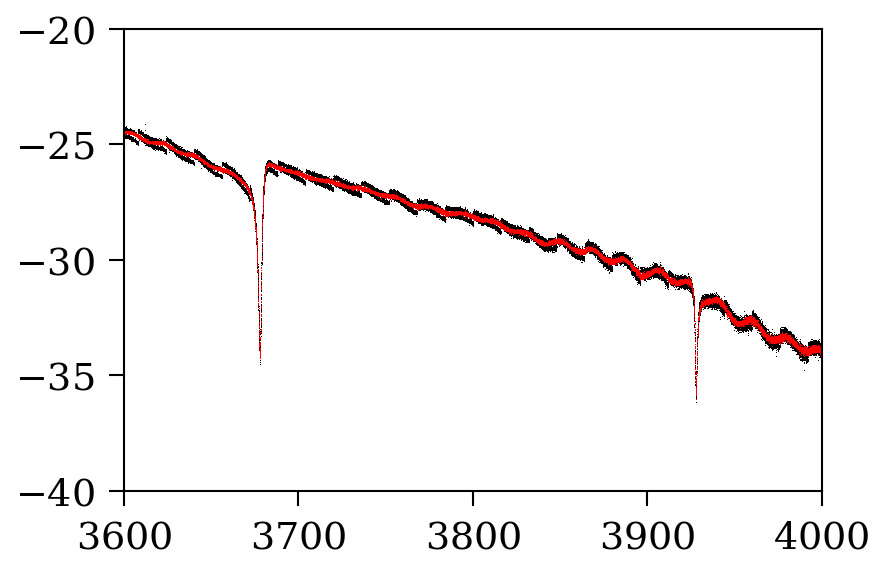

In [47]:
fig, ax = plt.subplots()
for sa in sweeps:
    ax.plot(sa.frequency_MHz, 20 * np.log10(np.abs(sa.s21_point)), ',k')
ax.plot(1e-6 * frequency, 20 * np.log10(amplitude), ',r')
ax.set_xlim(3600, 4000)
ax.set_ylim(-40, -20)

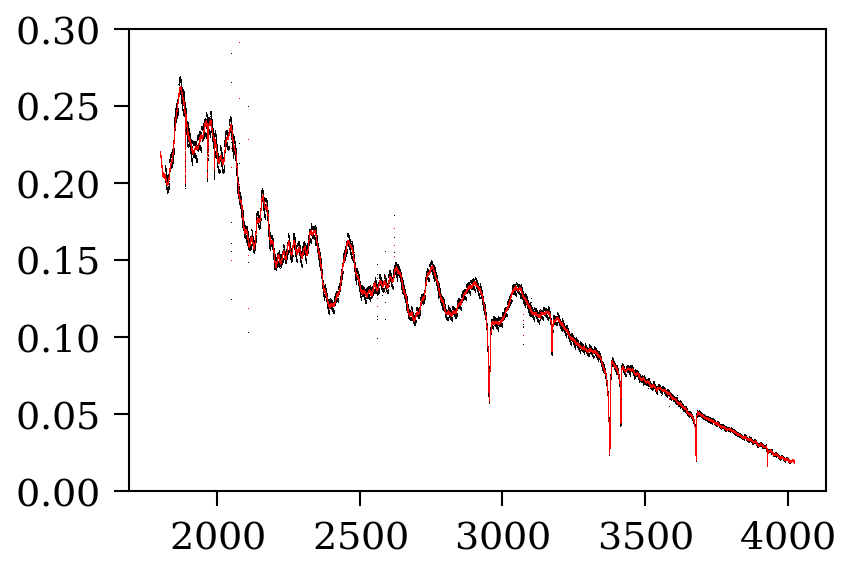

In [34]:
fig, ax = plt.subplots()
for sa in sweeps:
    ax.plot(sa.frequency_MHz, np.abs(sa.s21_point), ',k')
ax.plot(1e-6 * frequency, amplitude, ',r')
#ax.set_xlim(1800, 2200)
ax.set_ylim(0, 0.3);

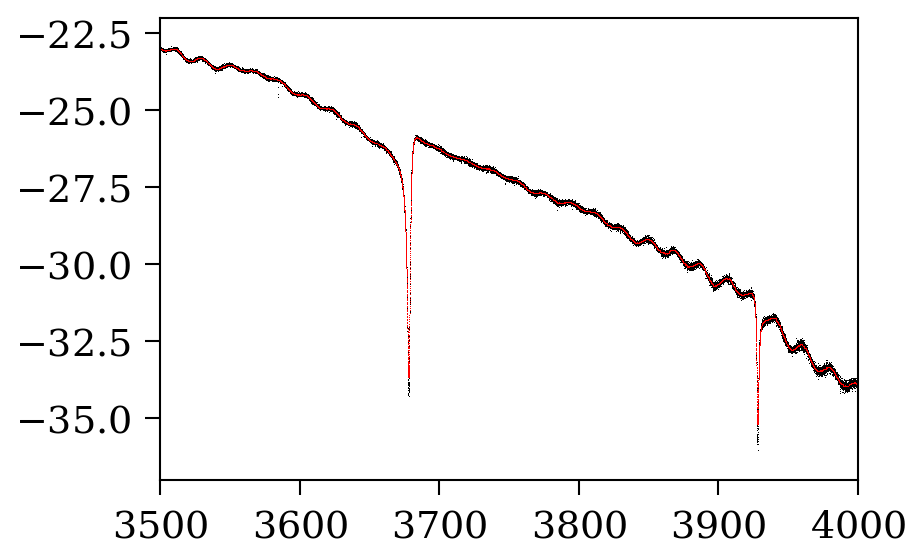

In [42]:
fig, ax = plt.subplots()
ax.plot(1e-6 * frequency, 20 * np.log10(amplitude), ',k')
ax.plot(1e-6 * frequency, 20 * np.log10(amplitude_smoothed), ',r')
ax.set_xlim(3500, 4000)
ax.set_ylim(-37, -22);

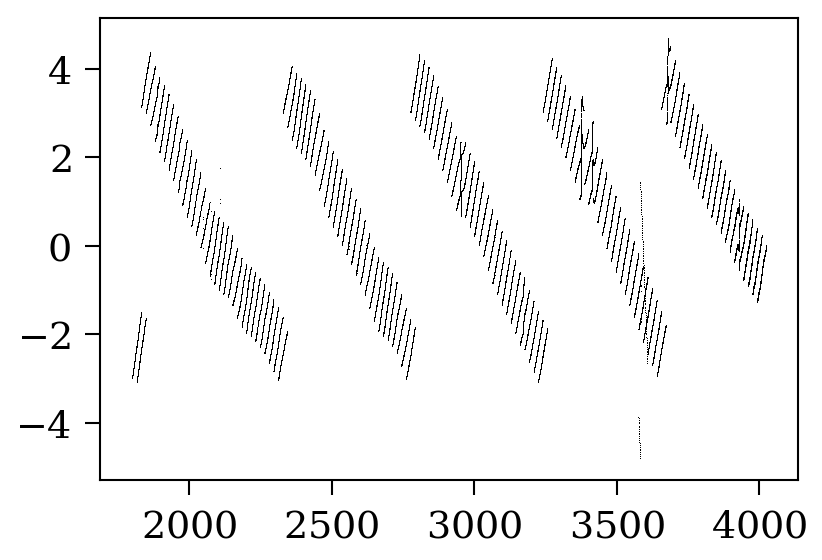

In [10]:
fig, ax = plt.subplots()
for sa in sweeps:
    ax.plot(sa.frequency_MHz, np.unwrap(np.angle(sa.s21_point)), ',k')